In [757]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams["figure.figsize"] = [12, 9]
matplotlib.style.use('ggplot')

%matplotlib inline

# Data exploration

In [758]:
def read_data(path):
    return pd.read_csv(path, 
                       index_col=False, 
                       skipinitialspace=True,
                       names=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                           'marital_status', 'occupation', 'relationship', 'race', 'sex',
                           'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
                           'income']
                       )

In [759]:
train = read_data('./data/adult/adult.data')
test = read_data('./data/adult/adult.test')

In [760]:
train = train.append(test)
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c215490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125bee490>]], dtype=object)

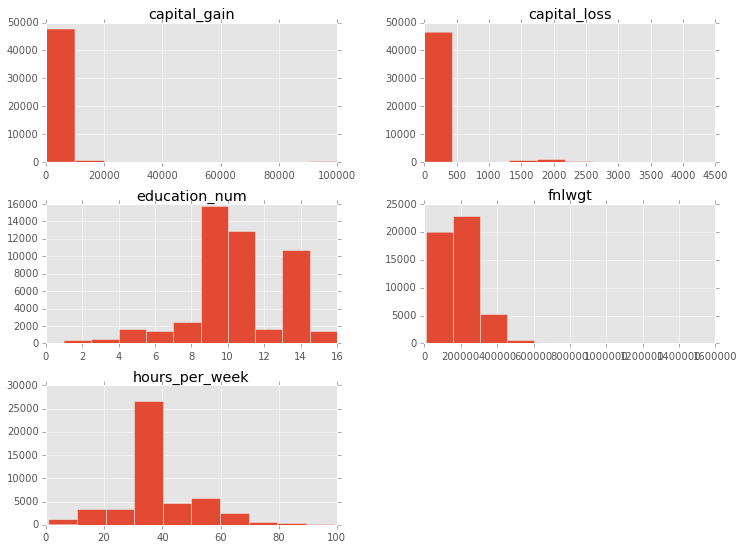

In [761]:
train.hist(figsize=(12, 9))

`age, education_num, hours_per_week, fnlwgt` seem like good candidates as features. Not much information in `capital_gain, capital_loss`.

## Some routine stuff
1. Convert objects to categories
2. Drop duplicates
3. Drop NA's - we can potentially impute these values. But always try out the simpler alternative before making it too complicated :)

In [762]:
# for column in train.select_dtypes(['object']).columns:
#     train[column] = train[column].astype('category')

## Check for duplicates, nulls
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)

print any(train.duplicated())
print train.isnull().any()

False
age               False
workclass         False
fnlwgt            False
education         False
education_num     False
marital_status    False
occupation        False
relationship      False
race              False
sex               False
capital_gain      False
capital_loss      False
hours_per_week    False
native_country    False
income            False
dtype: bool


Let's clean some data

In [763]:
train.income.loc[train.income == '>50K.'] = '>50K'
train.income.loc[train.income == '<=50K.'] = '<=50K'
train.income.value_counts()

<=50K    37128
>50K     11685
dtype: int64

## Intuition 1:
Higher education should result in more income.

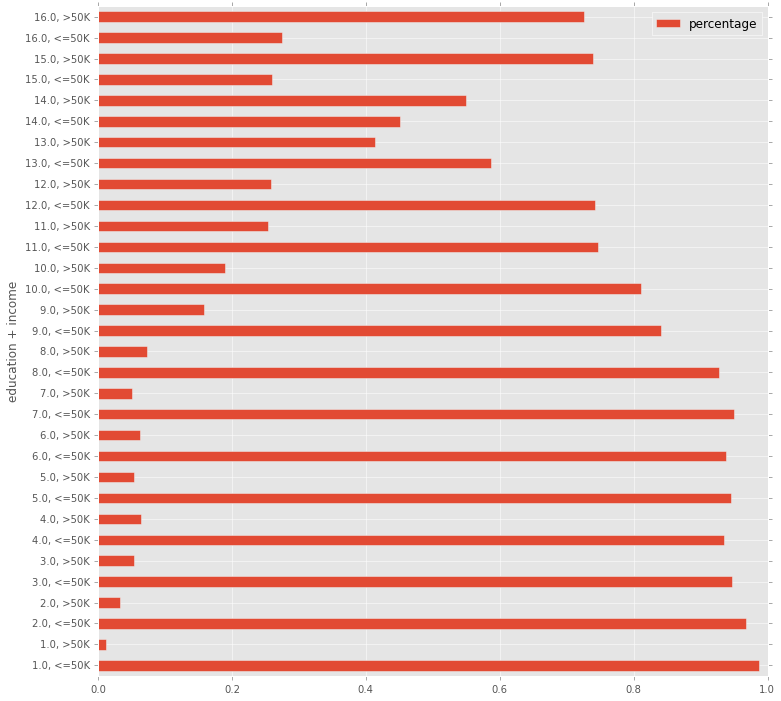

In [770]:
education_subset = train.groupby(['education_num', 'income']).size().reset_index()
education_subset.columns = ['education_num', 'income', 'count']
func = lambda x: float(x['count']) / train[train.education_num == x.education_num].count()[0]
education_subset['percentage'] = education_subset.apply(func, axis=1)
education_subset['education + income'] = education_subset.apply(lambda x: '%s, %s' % (x.education_num, x.income), axis=1)
education_subset.sort().plot(kind='barh', x='education + income', y='percentage', figsize=(12,12))

Above plot shows percentage of population with respect to education and income, and it seems people with Masters and PhD tend to earn to more (more number of people are in >50K bucket).

## Intuition 2:
People earn more as they get more experience.

income
<=50K    [[Axes(0.125,0.684722;0.336957x0.215278), Axes...
>50K     [[Axes(0.125,0.684722;0.336957x0.215278), Axes...
dtype: object

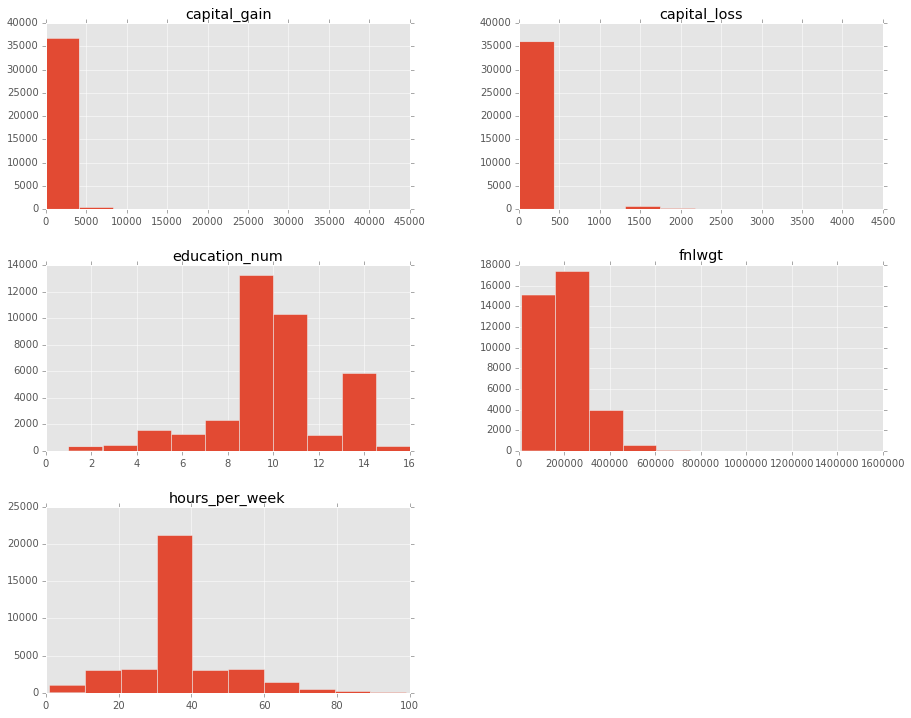

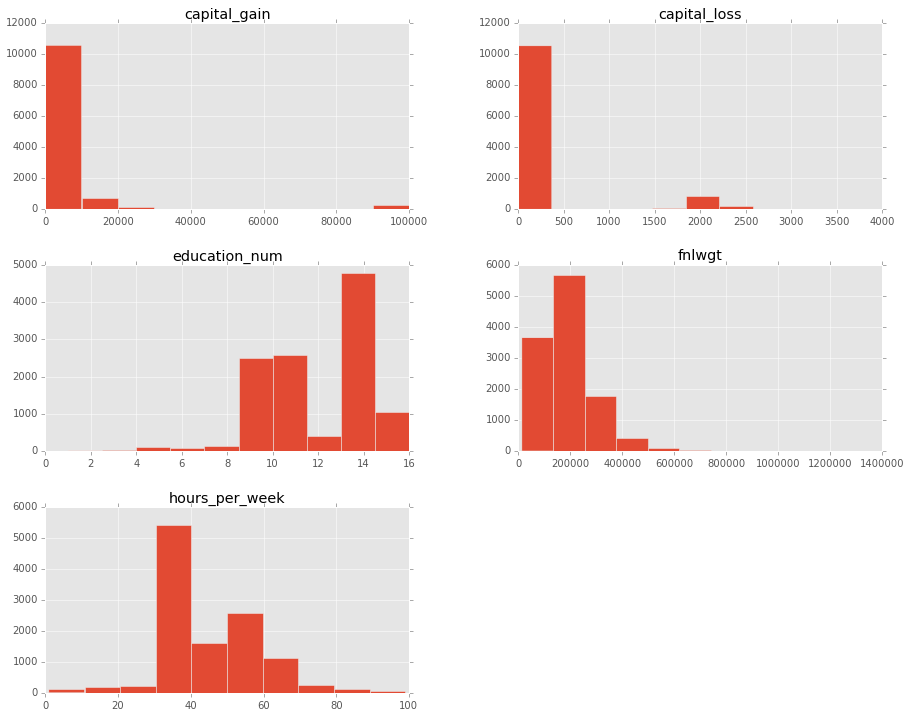

In [786]:
train.groupby('income').hist(figsize=(15,12))

First plot shows distribution of age with respect to income <= 50K. Age is used as an proxy to experience. Assumption here is people continue to work as they age and acquire more skills in the process. As per intuition, number of people making less than 50K decreases as per age.

Second plot shows income > 50K. More interestingly, data shows a peak around 45. This indicates either there aren't enough poeple of age 45+ earning more than 50K in the data or income decreases as people approach retirement.

# Feature construction

In [810]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [817]:
lencoder = LabelEncoder()
oencoder = OneHotEncoder()

In [843]:
features = pd.DataFrame()
features['age'] = train['age']
features['education_num'] = train['education_num']
features['hours_per_week'] = train['hours_per_week']
features['fnlwgt'] = train['fnlwgt']
features['sex'] = lencoder.fit_transform(train.sex)
features['occupation'] = lencoder.fit_transform(train.occupation)

features.income = train.income
features.income = lencoder.fit_transform(features.income)
features.head()

,age,education_num,hours_per_week,fnlwgt,sex,occupation
0,39,13,40,77516,1,1
1,50,13,13,83311,1,4
2,38,9,40,215646,1,6
3,53,7,40,234721,1,6
4,28,13,40,338409,0,10


# Model fitting

In [836]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [837]:
x_train, x_test, y_train, y_test = train_test_split(features.drop('income'), features.income)

In [838]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [839]:
y_hat = model.predict(x_test)

# Model/Feature Evaluation

In [840]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [841]:
accuracy_score(y_test, y_hat)

0.79260898066207797

In [842]:
confusion_matrix(y_test, y_hat)

array([[8456,  850],
       [1681, 1217]])